# Dropout in Fully Connected Layers

## Purpose
We test whether applying dropout to the **fully connected layers** reduces overfitting and improves generalization.  
This notebook compares FC dropout performance against the baseline.  

In [1]:
import os
import sys

current_dir = os.getcwd()
package_path = os.path.abspath(os.path.join(current_dir, '..'))

if package_path not in sys.path:
    sys.path.insert(0, package_path)

In [2]:
import torch
from PIL import Image

from config.paths import PathConfig # Path config

from src.model import MiniCNN, ConvBlock, FCBlock
from src.train import trainModel
from src.data import CustomDataset, load_cifar_10_data, check_data_loading, Loader, class_to_idx
from src.visualizations import plotFmaps_and_activationHist, plotCurves
from src.utils import EarlyStopping, unpickle, loadWeights, readJson, genError, saveHistory, evalModel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
paths = PathConfig("regularization-ml", "regularization-data")
PROJECT_DIR = paths.project
DATA_DIR = paths.data
BASE_DIR = paths.root

## Dataset
Same setup as baseline (CIFAR-10, minimal preprocessing to the training set [normalization, randomCrop w/ padding=4, colorJitter, and randomHorizontalFlip w/ p=0.3])


In [ ]:
""" If using Colab, uncomment this
# Copy once from Drive
!cp $DATA_DIR/cifar-10-python.tar.gz /content/

# Extract locally
!mkdir /content/dataset/
!tar -xzf /content/cifar-10-python.tar.gz -C /content/dataset/
"""

In [ ]:
""" If running on local, uncomment this
!mkdir $DATA_DIR/dataset/
!tar -xzf $DATA_DIR/cifar-10-python.tar.gz -C $DATA_DIR/dataset/
"""

In [6]:
LOCAL_DATA = f"{DATA_DIR}/dataset" # path to cifar-10 dataset
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cifar_10_data(LOCAL_DATA)

In [7]:
# Creates train, test, and val loaders
train_loader, val_loader, test_loader = Loader(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Starting Data Loading...
⚠️  CUDA not available, using CPU
📁 Loading datasets...
✅ Datasets loaded successfully
Training samples: 40000
Validation samples: 10000
Batch size: 64
🔍 Testing data loading...
✅ Train batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
   Input range: [-1.989, 2.126]
   Label range: [0, 9]
✅ Val batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Model Definition
Baseline CNN + dropout in the fully connected layers.  
- Dropout probability tested: p ∈ {0.3, 0.5, 0.7}  
- Other architecture/hyperparameters unchanged.

Firstly, we test for p = 0.3.

## Training Setup
Identical to baseline: AdamW, lr=0.01, decay_factor=0.01, lr annealing, batch_size=64, num_epochs dependent on early stopping. Patience is higher, raised to 10.

Only difference: dropout added after dense layers.



---
---

## Exp1: FC dropout p = 0.3
We change the probability of dropout occuring in the fc layer to 0.3, the feature extractor remains the same.

In [10]:
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False),
    ConvBlock(128, 128)
]

fc3_layer = [
    FCBlock(128, 64, True, 0.3),
    torch.nn.Linear(64, 10)
]

drop_3_model = MiniCNN(base_conv_layers, fc3_layer)

In [ ]:
"""
history_drop3 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.3"
path = f"{DATA_DIR}/weights"
fc3model = trainModel(drop_3_model, history_drop3, train_loader, val_loader, model_type, path, 10)
"""

In [ ]:
"""
history_path = f"../logs/fc0.3.json"
saveHistory(history_drop3, history_path) # Saves the training metadata to a json file
"""

The model was able to train for 57 epochs before early stopping was triggered, not accounting for the extra 3 alloted epochs, that totals, 5 more epochs than baseline. We could attribute this to either the dropout imbubed layers or better weight initialization.

In [11]:
visuals_folder3 = f"../visualizations/fc0.3"
weights_path = f"{DATA_DIR}/weights/fc0.3.pth"
fc3model = loadWeights(drop_3_model, weights_path)

In [12]:
fc3_json = f"../logs/fc0.3.json"
fc3_data = readJson(fc3_json) # method reads the training metadata from a json file.

### Loss and Accuracy Plots
With Dropout, training and validation accuracies exhibit a smaller gap than the baseline, demonstrating its regularization effect. The validation loss stays lower than the training loss for more epochs during training. An effect of dropout.


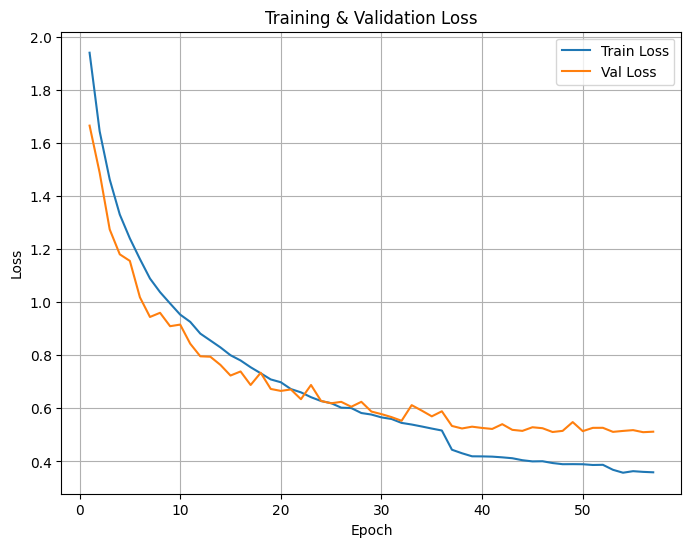

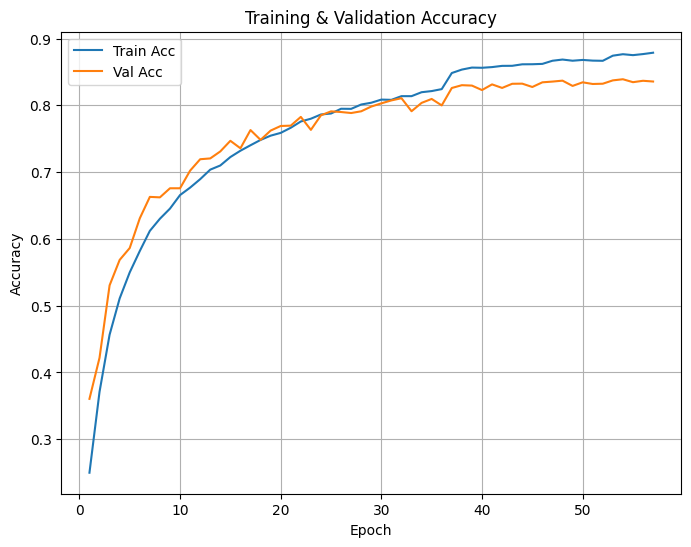

In [13]:
train_losses_fc3 = fc3_data["train_loss"]
val_losses_fc3 = fc3_data["val_loss"]
train_accs_fc3 = fc3_data["train_acc"]
val_accs_fc3 = fc3_data["val_acc"]
plotCurves(train_losses_fc3, val_losses_fc3, train_accs_fc3, val_accs_fc3, visuals_folder3)

### Generalization gap
Mean gap: 0.020

Std: 0.10

Range: [-0.27, 0.16]

___

Dropout when p = 0.3, reduces the final gap (mean ± std) from μ=0.077±0.10 to μ=0.02±0.010, and compresses the gap range from [-0.26, 0.20] to [-0.27, 0.16] (range ↓6.5%).

A lower mean gap than baseline is also observed.


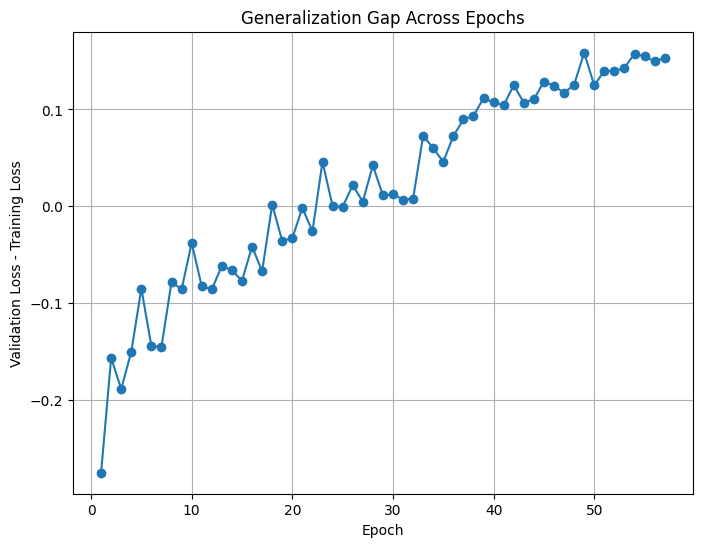

In [14]:
genError(visuals_folder3, train_losses_fc3, val_losses_fc3)

---
---

## Exp2: Dropout p = 0.5

The same model architecture, dataset, augmentations as exp 1, but dropout in the fc layer is increased to 0.5

In [15]:
# p = 0.5 in the model definition.
fc5_layer = [
    FCBlock(128, 64, True, 0.5),
    torch.nn.Linear(64, 10)
]

drop_5_model = MiniCNN(base_conv_layers, fc5_layer)

In [ ]:
"""
history_drop5 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.5"
path = f"{DATA_DIR}/weights"
fc5model = trainModel(drop_5_model, history_drop5, train_loader, val_loader, model_type, path, 10)
"""

The model was able to train for the alloted 70 epochs, early stopping was not triggered. Validation loss continued to drop steadily.

In [ ]:
"""
history_path5 = f"../logs/fc0.5.json"
saveHistory(history_drop5, history_path5) # Saves the training metadata to a json file
"""

In [16]:
visuals_folder5 = f"../visualizations/fc0.5"
weights_path = f"{DATA_DIR}/weights/fc0.5.pth"
fc5model = loadWeights(drop_5_model, weights_path)

### Model evaluation
This model got the highest test accuracy for dropout in the FC layers experiments with ~84%.

Accuracy: 0.8148
              precision    recall  f1-score   support

           0     0.8393    0.8200    0.8295      1000
           1     0.8980    0.9240    0.9108      1000
           2     0.7643    0.7230    0.7431      1000
           3     0.6670    0.6390    0.6527      1000
           4     0.7757    0.7780    0.7768      1000
           5     0.7703    0.7480    0.7590      1000
           6     0.8045    0.8600    0.8313      1000
           7     0.8450    0.8450    0.8450      1000
           8     0.8745    0.9200    0.8967      1000
           9     0.8955    0.8910    0.8932      1000

    accuracy                         0.8148     10000
   macro avg     0.8134    0.8148    0.8138     10000
weighted avg     0.8134    0.8148    0.8138     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

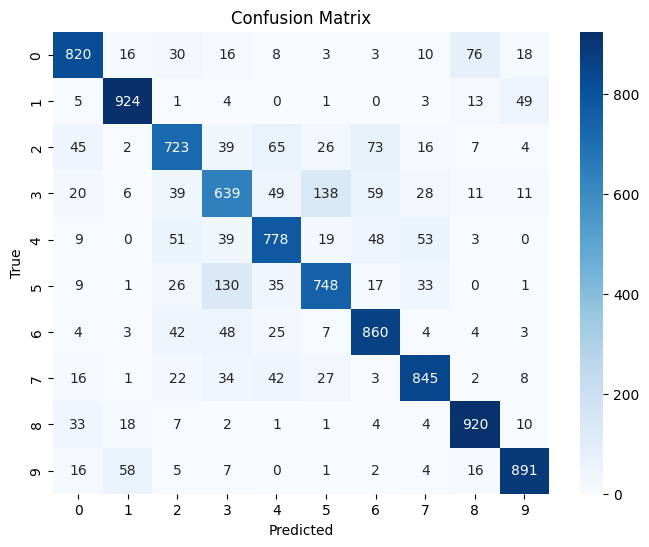

In [17]:
evalModel(fc5model, visuals_folder5, test_loader) #Best Performer!

---
---

## Exp 3: 0.7

Same old, but p = 0.7

In [18]:
# p = 0.7 in the model definition.
fc7_layer = [
    FCBlock(128, 64, True, 0.5),
    torch.nn.Linear(64, 10)
]

drop_7_model = MiniCNN(base_conv_layers, fc7_layer)

In [ ]:
"""
history_drop7 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.7"
path = f"{DATA_DIR}/weights"
fc7model = trainModel(drop_7_model, history_drop7, train_loader, val_loader, model_type, path, 10)
"""

The model trained for 62 epochs before early stopping triggered.

In [ ]:
"""
history_path7 = f"../logs/fc0.7.json"
saveHistory(history_drop7, history_path7) # Saves the training metadata to a json file
"""

In [19]:
visuals_folder7 = f"../visualizations/fc0.7"
weights_path = f"{DATA_DIR}/weights/fc0.7.pth"
fc7model = loadWeights(drop_7_model, weights_path)

fc7_json = f"../logs/fc0.7.json"
fc7_data = readJson(fc7_json)

### Loss and Accuracy Plots
With higher dropout, the training and validation loss curves align more closely. This suggests that dropout strengthens regularization, reducing overfitting and producing the observed effect.

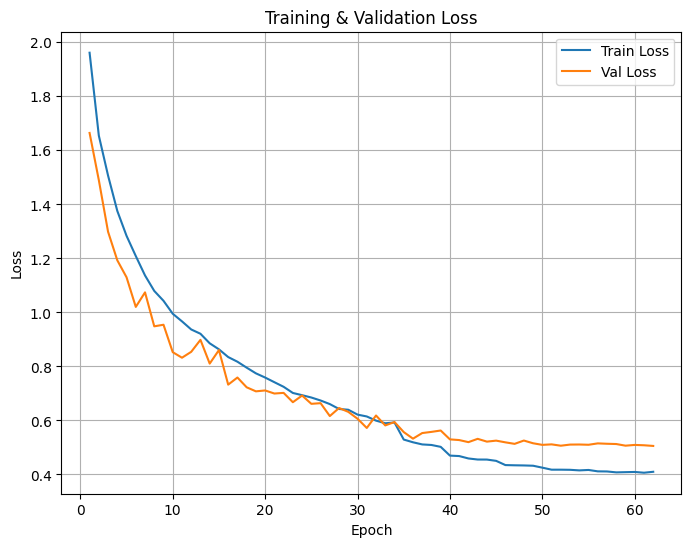

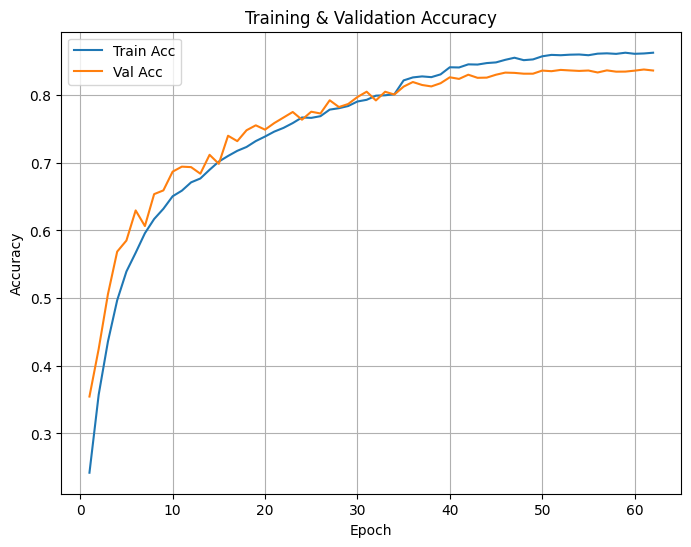

In [20]:
train_losses_fc7 = fc7_data["train_loss"]
val_losses_fc7 = fc7_data["val_loss"]
train_accs_fc7 = fc7_data["train_acc"]
val_accs_fc7 = fc7_data["val_acc"]
plotCurves(train_losses_fc7, val_losses_fc7, train_accs_fc7, val_accs_fc7, visuals_folder7)

### Generalization gap
Mean gap: -0.005

Std: 0.095

Range: [-0.29, 0.10]

___

Dropout when p = 0.3, reduces the final gap (mean ± std) from μ=0.077±0.103 (baseline) to μ=-0.005±0.095, and compresses the gap range from [-0.26, 0.20] to [-0.29, 0.10] (range ↓15%).

2.3x(130.7%) a lower range than when p = 3.

## Results
Validation accuracy per dropout rate:  

| Model                | Val Acc | Test Acc |  
|----------------------|---------|----------|  
| Baseline             | 82.4%   | 81.8%    |  
| FC Dropout (p=0.3)   | 83.9%   | 81.7%    |  
| FC Dropout (p=0.5)   | 83.7%   | 83.8%    |  
| FC Dropout (p=0.7)   | 83.8%   | 81.0%    |  

## Discussion
- Dropout at p=0.5 gave best performance.  
- Very high dropout (p=0.7) hurt training stability, but showed highest regularization effects.
- Confirms hypothesis that moderate dropout improves generalization.  

## Conclusion
Dropout in fully connected layers improved accuracy by ~2% over the baseline, with p=0.5 performing best.